# CNN to predict MNIST images using TensorFlow

In [94]:
# imports 
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [52]:
data = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


## Building TF graph

### Define placeholders

In [53]:
# create an input node, shape is 28*28 for the number of pixels and None for batch_size(as in variable batch size)
x = tf.placeholder(tf.float32, shape=[None, 28*28], name='x')

# we reshape x to a 4d tensor of size [-1, 28, 28, 1], 28 for image height and width, 1 for channel
x_train = tf.reshape(x, [-1, 28, 28, 1])

# the expected output 
y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y_')
y_cls = tf.arg_max(y_, dimension=1)

### Conv layer 1

The first conv layer uses 32 filters of shape 5x5.

In [54]:
# init weights and bias

# here we get truncated_normal values with a std deviation of 0.1
# the shape is - [5, 5, 1, 16] for 5x5 filter, 1 input channel (as mnist is grey-scale), and 16 output channels
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 16], stddev=0.1))

# bias for each of the 16 output channels
b_conv1 = tf.Variable(tf.constant(0.1, shape=[16]))

In [55]:
# create a conv layer
# input is x_train, specifies the input to the layer
# filers are the weights 
# stride is [1, 1, 1, 1], the first and last are always 1, first for image number and the last for input channel
# for a 2x2 stride, use [1, 2, 2, 1]
# padding = same, the input image is padded with 0, to make output of same size
conv1 = tf.nn.conv2d(input=x_train, filter=W_conv1, strides=[1, 1, 1, 1], padding='SAME')

# add the bias 
conv1_plus_b = conv1 + b_conv1

# max pool this layer
# the value is the layer to pool upon
# ksize?
pool1 = tf.nn.max_pool(value=conv1_plus_b, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# apply relu
# basically computers max(x, 0) for each x
relu1 = tf.nn.relu(pool1)

In [56]:
relu1

<tf.Tensor 'Relu_5:0' shape=(?, 14, 14, 16) dtype=float32>

### Conv layer 2

Same as above, build second conv layer

In [57]:
# weight and bias
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 16, 32], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[32]))

# build layer
conv2 = tf.nn.conv2d(input=relu1, filter=W_conv2, strides=[1, 1, 1, 1], padding='SAME')
conv2_plus_b = conv2 + b_conv2
pool2 = tf.nn.max_pool(value=conv2_plus_b, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
relu2 = tf.nn.relu(pool2)

In [58]:
relu2

<tf.Tensor 'Relu_6:0' shape=(?, 7, 7, 32) dtype=float32>

### Flatten layer

The conv layer 2 outputs a 4d tensor, but we need a 2d tensor for the fully connected layer, thus this flatten layer

In [59]:
flat_layer = tf.reshape(relu2, [-1, 7 * 7 * 32])

In [60]:
flat_layer

<tf.Tensor 'Reshape_10:0' shape=(?, 1568) dtype=float32>

### Fully connected layer 1

Our first fully connected layer, with 128 neurons.

In [61]:
# weight and bias
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 32, 128], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[128]))

# fc layer
math_fc1 = tf.matmul(flat_layer, W_fc1) + b_fc1
fc1 = tf.nn.relu(math_fc1)

In [62]:
fc1

<tf.Tensor 'Relu_7:0' shape=(?, 128) dtype=float32>

### Dropout layer

This layer randomly drops a few neurons, to reduce overfitting

In [63]:
keep_prob = tf.placeholder(tf.float32)
drop_out = tf.nn.dropout(fc1, keep_prob)

In [64]:
drop_out

<tf.Tensor 'dropout_1/mul:0' shape=(?, 128) dtype=float32>

### Fully connected layer 2

Scrond FC layer, has 10 neurons, each for one of the digits

In [65]:
# weight and bias
W_fc2 = tf.Variable(tf.truncated_normal([128 ,10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))

# fc layer
fc2 = tf.matmul(drop_out, W_fc2) + b_fc2

In [66]:
fc2

<tf.Tensor 'add_11:0' shape=(?, 10) dtype=float32>

### Softmax layer

Add a softmax layer to normalize the output, and use argmax to get digit

In [67]:
y_pred = tf.nn.softmax(fc2)
y_pred_cls = tf.arg_max(y_pred, dimension=1)

In [68]:
y_pred_cls

<tf.Tensor 'ArgMax_3:0' shape=(?,) dtype=int64>

We have finished building out CNN

### Defining cost function and optimizer

In [69]:
# cost (to minimize)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_)
cost = tf.reduce_mean(cross_entropy)

# using adamoptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# pref measures
correct_pred = tf.equal(y_pred_cls, y_cls)
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

In [70]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [ ]:
saver = tf.train.Saver()
saver.restore(session, "../models/tf_cnn_6k.ckpt")

In [78]:
batch_size = 512

In [72]:
# helper to optimize
tot_iter = 0

def optimize(num_iter):
    global tot_iter
    
    for i in range(tot_iter, tot_iter + num_iter):
        
        x_batch, y_batch = data.train.next_batch(batch_size)
        f_d = {x: x_batch, y_: y_batch, keep_prob: 0.5}
        
        session.run(optimizer, feed_dict=f_d)
        
        if i % 100 == 0:
            a = session.run(acc, f_d)
            msg = "Iteration: {0:>6}, Acc: {1:6.1%}"
            print(msg.format(i + 1, a))
            
        tot_iter += 1

In [95]:
from sklearn.metrics import confusion_matrix

data_cls = np.argmax(data.test.labels, axis=1)
def acc_test():
    y_pred = session.run(y_pred_cls, feed_dict={
        x: data.test.images,
        y_: data.test.labels,
        keep_prob: 1.0
    })
    
    correct = (y_pred == data_cls)
    correcr_sum = correct.sum()
    
    acc = correcr_sum/len(data_cls)
    msg = "Pred acc: {0:6.1%}"
    print(msg.format(acc))    
    
    print("\nConfusion matrix")
    cm = confusion_matrix(y_pred=y_pred, y_true=data_cls)
    print(cm)
    
    plt.matshow(cm)
    plt.colorbar()
    plt.xlabel('Pred')
    plt.ylabel('True')

### Optimize

In [77]:
optimize(1000)

Iteration:    101, Acc:  55.8%
Iteration:    201, Acc:  74.9%
Iteration:    301, Acc:  83.2%
Iteration:    401, Acc:  85.2%
Iteration:    501, Acc:  89.2%
Iteration:    601, Acc:  90.2%
Iteration:    701, Acc:  92.0%
Iteration:    801, Acc:  94.1%
Iteration:    901, Acc:  91.6%
Iteration:   1001, Acc:  93.8%


In [88]:
acc_test()

Pred acc:  96.3%


After about 1k iterations, train acc is at 93%
<br>Strangely, test acc is 97%??

In [89]:
optimize(2000)

Iteration:   1101, Acc:  93.2%
Iteration:   1201, Acc:  93.8%
Iteration:   1301, Acc:  94.9%
Iteration:   1401, Acc:  95.3%
Iteration:   1501, Acc:  95.3%
Iteration:   1601, Acc:  96.1%
Iteration:   1701, Acc:  96.3%
Iteration:   1801, Acc:  94.7%
Iteration:   1901, Acc:  96.1%
Iteration:   2001, Acc:  95.7%
Iteration:   2101, Acc:  95.5%
Iteration:   2201, Acc:  95.3%
Iteration:   2301, Acc:  96.9%
Iteration:   2401, Acc:  96.7%
Iteration:   2501, Acc:  98.2%
Iteration:   2601, Acc:  95.9%
Iteration:   2701, Acc:  98.0%
Iteration:   2801, Acc:  96.7%
Iteration:   2901, Acc:  96.9%
Iteration:   3001, Acc:  97.5%


In [90]:
acc_test()

Pred acc:  98.3%


After 3k iterations, we have 98% on test class

In [91]:
optimize(3000)

Iteration:   3101, Acc:  97.3%
Iteration:   3201, Acc:  96.9%
Iteration:   3301, Acc:  97.5%
Iteration:   3401, Acc:  96.7%
Iteration:   3501, Acc:  97.5%
Iteration:   3601, Acc:  98.8%
Iteration:   3701, Acc:  98.6%
Iteration:   3801, Acc:  97.5%
Iteration:   3901, Acc:  98.4%
Iteration:   4001, Acc:  96.9%
Iteration:   4101, Acc:  97.3%
Iteration:   4201, Acc:  97.7%
Iteration:   4301, Acc:  97.5%
Iteration:   4401, Acc:  97.3%
Iteration:   4501, Acc:  98.0%
Iteration:   4601, Acc:  98.8%
Iteration:   4701, Acc:  96.5%
Iteration:   4801, Acc:  98.2%
Iteration:   4901, Acc:  98.4%
Iteration:   5001, Acc:  97.5%
Iteration:   5101, Acc:  97.7%
Iteration:   5201, Acc:  97.9%
Iteration:   5301, Acc:  98.2%
Iteration:   5401, Acc:  98.4%
Iteration:   5501, Acc:  98.4%
Iteration:   5601, Acc:  98.6%
Iteration:   5701, Acc:  97.7%
Iteration:   5801, Acc:  97.5%
Iteration:   5901, Acc:  98.6%
Iteration:   6001, Acc:  98.8%


In [92]:
acc_test()

Pred acc:  98.9%


After 6k iterations, test acc is around 99%

Pred acc:  98.9%

Confusion matrix
[[ 975    0    0    0    0    0    1    1    3    0]
 [   0 1130    3    0    0    0    0    1    1    0]
 [   2    0 1023    0    0    0    0    3    4    0]
 [   0    0    1 1003    0    2    0    1    2    1]
 [   0    0    2    0  975    0    1    0    2    2]
 [   2    0    0    6    0  878    3    1    0    2]
 [   4    2    0    1    1    2  946    0    2    0]
 [   0    1    7    3    0    0    0 1014    1    2]
 [   3    0    2    1    2    0    0    2  960    4]
 [   4    3    0    2    3    2    0    3    2  990]]


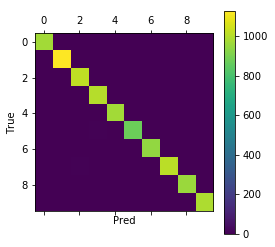

In [96]:
acc_test()

From the confusion matrix, we can see that the most confused are (3, 8) and (2, 5)

## Save Model

In [97]:
saver = tf.train.Saver()
sp = saver.save(session, "../models/tf_cnn_6k.ckpt")
print("Save in {0}".format(sp))

Save in ../models/tf_cnn_6k.ckpt


## Close session! Very IMP!!

In [98]:
session.close()